In [1]:
import astropy.io.fits as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import multiprocessing
import subprocess
import glob
import re
import h5py
%matplotlib inline

### Directorios del proyecto

In [2]:
DIR_PROYECTO       = '/home/matias/tesis/'

DIR_MOSAICOS       = DIR_PROYECTO + 'eagle/*/regiones/'
DIR_CATÁLOGOS      = DIR_PROYECTO + 'eagle/*/catálogos/'
DIR_SEGMENTACIONES = DIR_PROYECTO + 'eagle/*/segmentaciones/'
DIR_MORFOLOGÍAS    = DIR_PROYECTO + 'morfologías/'
DIR_DATOS_EAGLE    = DIR_PROYECTO + 'tablas/'
DIR_LOTZ           = DIR_PROYECTO + 'gm20/'

### Definición de valores de filtro

In [3]:
valores_filtros = {
    'u': 121671348.887,
    'g': 168273491.446,
    'r': 178848396.083,
    'i': 69397708.7252,
    'z': 59157262.0017,
    'upri': 126207773.267,
    'gpri': 149732062.76,
    'rpri': 188318397.068,
    'ipri': 67579475.1401,
    'zpri': 50496673.9991,
}

### Generación del mapa de pesos

In [4]:
hdu = pf.PrimaryHDU(np.ones((256, 256)))
hdu.writeto(DIR_PROYECTO + 'wht1.fits', overwrite=True)

### Generación de archivos para correr el programa de Lotz en modo 'batch'
`zeropt.dat` tiene las magnitudes de base de los mosaicos y `run_gmorph.pro` los mosaicos a procesar. Se generan en el mismo bucle para que el orden de las magnitudes se corresponda con el de los mosaicos.

Borramos los lotes existentes...

In [88]:
for file in glob.glob('*.pro'):
    os.remove(file)

Debido a un error del programa de Lotz que hace que el IDL arroje la excepción "program code area full" en vez de generar un único lote con todos los mosaicos a procesar, generamos varios lotes de hasta $N$ mosaicos cada uno (chunk size, recomendación $N=2$). 

In [33]:
# yield successive n-sized chunks from l
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [92]:
N = 1 # chunk size

for filtro_orientación in os.listdir('../eagle'):
    nombre_filtro = filtro_orientación.split('_')[0]
    
    for index, chunk in enumerate(chunks(os.listdir('../eagle/' + filtro_orientación + '/regiones'), N)):
    
        with open('run_gmorph_' + filtro_orientación + '_%02d.pro' % index, 'w') as run_gmorph:
    
            for región in chunk:
                
                fits = pf.open('../eagle/' + filtro_orientación + '/regiones/' + región)
                
                flujo_total_filtro    = np.sum(fits[0].data) / valores_filtros[nombre_filtro] # flujo total / valor de filtro
                magnitud_total_filtro = -2.5 * np.log10(flujo_total_filtro / (3.631e6 * 4.8532896**2))

                nombre = os.path.splitext(región)[0] # separa el nombre del archivo de su extensión

                comando = "get_gmorph_new, 0, '%s', '%s', '%s', '%s', '%s', %s" % (                             \
                    # catálogo
                    '/home/matias/tesis/eagle/' + filtro_orientación + '/catálogos/'      + nombre + '.cat',    \
                    # región
                    '/home/matias/tesis/eagle/' + filtro_orientación + '/regiones/'       + nombre + '.reg',    \
                    # mapa de pesos
                    '/home/matias/tesis/wht1.fits',                                                             \
                    # mapa de segmentación
                    '/home/matias/tesis/eagle/' + filtro_orientación + '/segmentaciones/' + nombre + '.seg',    \
                    # archivo de salida
                    '/home/matias/tesis/morfologías/' + nombre + '.morph',                                      \
                    # magnitud total filtro
                    magnitud_total_filtro                                                                       \
                )

                # Cada línea luce como: get_gmorph_new, 0, 'xxx.cat', 'xxx.reg', 'wht1.fits', 'xxx.seg', 'xxx.morph'
                # "where 0 is the line number in xxx.cat of the starting object"
                run_gmorph.write(comando + '\n')

            run_gmorph.write('exit')

In [4]:
import scipy

In [6]:
scipy.special.lpmv(1, 1, .9)

-0.43588989435406728

Borramos las morfologías existentes...

In [93]:
for file in glob.glob('../morfologías/*.morph'):
    os.remove(file)

Procesamos los lotes con IDL; lo hacemos en paralelo para aprovechar todos los núcleos de la computadora.

In [ ]:
def idl(x):
    subprocess.run(['idl', x])
    
with multiprocessing.Pool(3) as p:
    p.map(idl, glob.glob('*.pro'))

Unimos todos los archivos creados por el programa de Lotz en uno solo. Hay una galaxia por archivo. Además extraemos la ID de la galaxia del nombre del archivo —ya que el programa de Lotz no se fija en esto— y la incluimos dentro del archivo que estamos generando para después tenerlas a mano.

In [111]:
with open('compendio.morph', 'w') as compendio:
    for file in glob.glob('../morfologías/*.morph'):
        m = re.search('(?P<filtro>\w)_gal(?P<orientación>\w+)_(?P<id>\d+)', file)
        
        with open(file, 'r') as morfología:
            content = False
            
            for line in morfología:
                if line[0] != '#': # si no es un comentario...
                    compendio.write(m.group('id') + '\t' + m.group('filtro') + '\t' + m.group('orientación') + line)
                    content = True
            
            #if not content: print(file)

### Carga de la consulta a la base de datos de EAGLE

**Imágenes**

```
SELECT     
    sub.galaxyid, image_face, image_edge, image_box    
FROM     
    RefL0100N1504_subhalo  as sub,    
    RefL0100N1504_aperture as aps    
WHERE
    sub.galaxyid = aps.galaxyid    
  AND
    aps.aperturesize = 30
  AND
    aps.mass_star > 1e10
  AND
    sub.snapnum = 27
```

---

Esta consulta dice que hay 2200 FITS de galaxias. Van de MassType_star > 1e10 para arriba.

```
SELECT                    
    count(*)                 
FROM             
    RefL0100N1504_SubHalo             
WHERE              
    SnapNum = 28          
AND
    SubGroupNumber  =  0         
AND
    Image_box is not null      
AND
    MassType_star > 1e10
```

**Magnitudes**

```
 SELECT          
     gal.GalaxyID as id,
     (mag.u_nodust - mag.g_nodust) as ug,
     (mag.g_nodust - mag.r_nodust) as gr  
 FROM   
     RefL0100N1504_SubHalo as gal,  
     RefL0100N1504_Magnitudes as mag,  
     RefL0100N1504_Aperture as ape  
 WHERE    
     gal.SnapNum = 27 and        
     ape.Mass_Star > 1e10 and    
     ape.ApertureSize = 30 and   
    
     gal.GalaxyID = mag.GalaxyID and  
     gal.GalaxyID = ape.GalaxyID
```

In [78]:
eagle_mag = pd.read_csv('/home/matias/tesis/tablas/magnitudes.csv', comment='#')

# Magnitudes de SDSS a UBVRI (Jester 2005): U-B = 0.78 * (u-g) - 0.88
eagle_mag['UB'] = 0.78 * eagle_mag.ug - 0.88

**Star formation rates**

```
SELECT              
    gal.GalaxyID          as id,    
    gal.HalfMassRad_Star  as half_mass_r,    
    gal.MassType_Star     as mass,    
    gal.StarFormationRate as sfr,  
    gal.SubGroupNumber    as subgroup_number  
FROM       
    RefL0100N1504_SubHalo as gal      
WHERE        
    gal.Snapnum = 27
  AND
    gal.StarFormationRate > 0
```

In [89]:
eagle_sfr = pd.read_csv('/home/matias/tesis/tablas/sfr.csv', comment='#')

### Carga de las morfologías (salida del programa de Lotz)
Do not trust morphologies when `FLAG = 1` and/or `<S/N> < 2.5`  and/or `R_ell < 2 x PSF FWHM` (see Lotz et al. astro-ph/0509106).

In [5]:
encabezado = [
  'id',
  'filtro',
  'orientación',
  's_n',
  'r_ell', # elliptic petrosian radius
  'gini',
  'm20',
  'flag'
]

columnas = [0,1,2,8,12,22,23,24]

lotz = pd.read_csv('compendio.morph', names=encabezado, usecols=columnas, sep='\s+')

lotz.groupby(['filtro', 'orientación']).id.count()

filtro  orientación
g       face           3394
        rand           3392
r       face           3398
Name: id, dtype: int64

In [6]:
lotz = lotz[(lotz.flag == 0) & (lotz.s_n >= 2.5)]
lotz.drop(['s_n', 'r_ell', 'flag'], axis=1, inplace=True)

lotz.groupby(['filtro', 'orientación']).id.count()

filtro  orientación
g       face           2401
        rand           2598
r       face           3028
Name: id, dtype: int64

In [75]:
def F(gini, m20):
    f = np.abs(-0.693 * m20 + 4.95 * gini - 3.85)
    return np.where(gini >= 0.14 * m20 + 0.778, f, -f)

In [76]:
lotz['f'] = F(lotz.gini, lotz.m20)

### Join EAGLE con Lotz

In [79]:
df = pd.merge(eagle_mag, lotz, how='inner', on='id')

In [83]:
def plot_g_m20(filtro, orientación, marcador='.'):
    fig, ax = plt.subplots()
    
    df[(df.filtro == filtro) & (df.orientación == orientación)] \
        .plot.scatter(x='m20', y='gini', c='UB', s=5, edgecolor='none', cmap='rainbow', ax=ax, marker=marcador)
    
    if orientación == 'rand': orientación = 'random'
        
    plt.xlim(plt.xlim(-3,0)[::-1])
    plt.ylim(.3,.7)
    plt.xlabel('$M_{20}$')
    plt.ylabel('$G$')
    plt.title('UB magnitude, %s band, %s oriented' % (filtro, orientación))
    plt.savefig('u-b_gini_vs_m20_%s_%s.png' % (filtro, orientación))

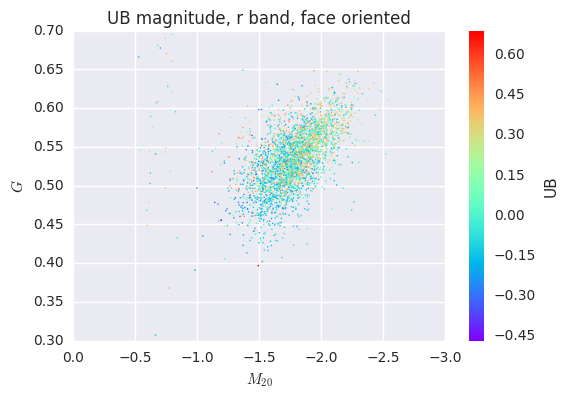

In [84]:
plot_g_m20('r', 'face')

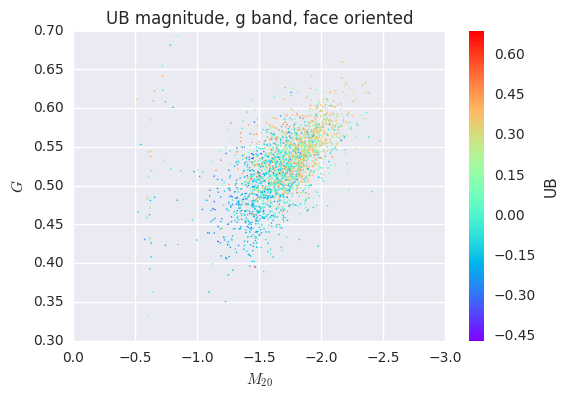

In [85]:
plot_g_m20('g', 'face')

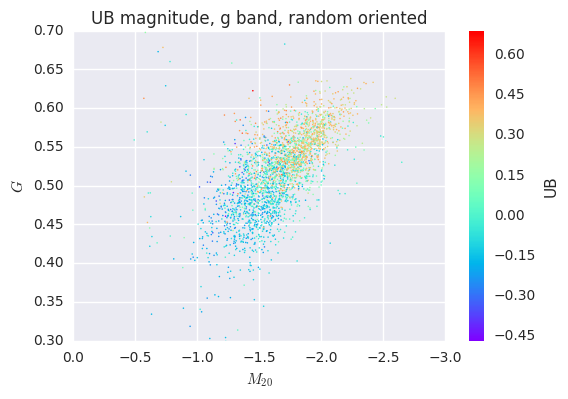

In [86]:
plot_g_m20('g', 'rand')

AttributeError: 'DataFrame' object has no attribute 'orientación'

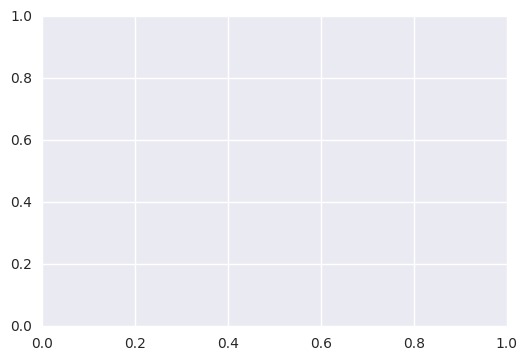

In [212]:
    fig, ax = plt.subplots()
    
    df[(df.filtro == 'g') & (df.orientación == 'face')] \
        .plot.scatter(x='m20', y='gini', c='r', s=5, edgecolor='none', ax=ax, marker='.', label='face')
    
    df[(df.filtro == 'g') & (df.orientación == 'rand')] \
        .plot.scatter(x='m20', y='gini', c='b', s=5, edgecolor='none', ax=ax, marker='.', label='random')
        
    ax.legend(loc=4, scatterpoints=100)
    plt.xlim(plt.xlim(-3,0)[::-1])
    plt.ylim(.3,.7)
    plt.xlabel('$M_{20}$')
    plt.ylabel('$G$')
    plt.title('g band, face and random orientations compared')
    plt.savefig('g_face_g_random_gini_vs_m20.png')

In [90]:
df = pd.merge(eagle_sfr, lotz, how='inner', on='id')

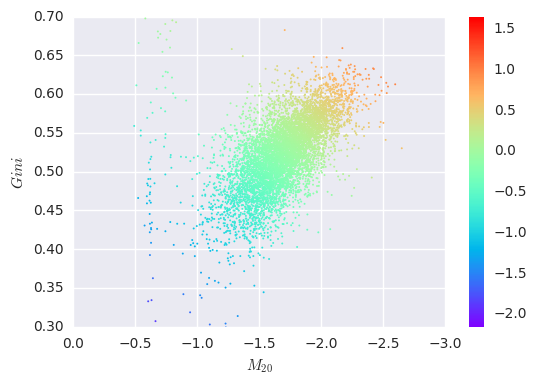

In [93]:
fig, ax = plt.subplots()
df.plot.scatter(x='m20', y='gini', c=df.f, s=2, edgecolor='none', cmap='rainbow', ax=ax)
plt.xlim(plt.xlim(-3,0)[::-1])
plt.ylim(0.3,0.7)
plt.xlabel('$M_{20}$')
plt.ylabel('$Gini$')
plt.savefig('F_gini_vs_m20.png')

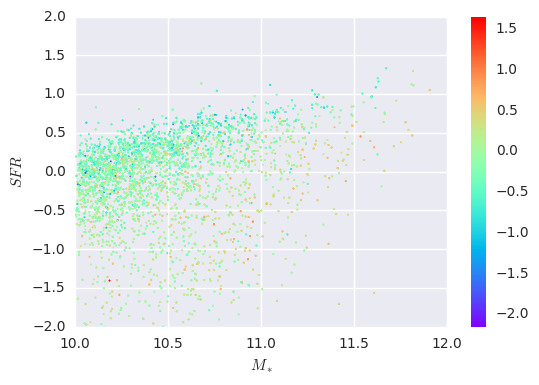

In [92]:
plt.scatter(x=np.log10(df.mass), y=np.log10(df.sfr), c=df.f, s=2, edgecolor='none', cmap='rainbow')
plt.colorbar()
plt.xlabel('$M_*$')
plt.ylabel('$SFR$')
plt.ylim(-2,2)
plt.xlim(10,12)
plt.savefig('SFR_vs_mass.png')

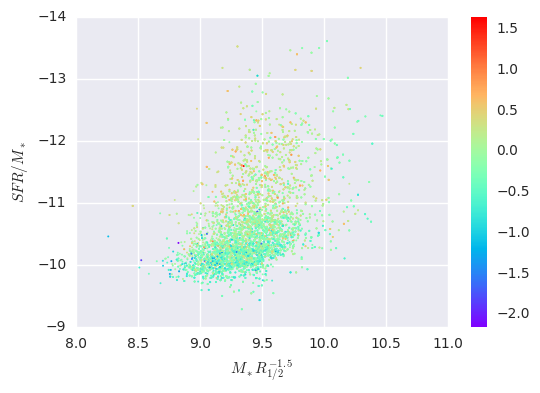

In [91]:
plt.scatter(x=np.log10(df.mass * np.power(df.half_mass_r, -1.5)), y=np.log10(df.sfr/df.mass), c=df.f, s=2, edgecolor='none', cmap='rainbow')
plt.ylim(plt.ylim()[::-1])
plt.colorbar()
plt.xlabel('$M_* R_{1/2}^{-1.5}$')
plt.ylabel('$SFR/M_*$')
plt.savefig('specific_SFR_vs_compactness.png')

In [97]:
morfologías = h5py.File('morphs.hdf5', 'r')

ea = pd.DataFrame()

ea['id'] = morfologías['GalaxyID']
ea['snapshot'] = morfologías['SnapshotNumber']
ea['e'] = morfologías['DiscMassFraction30kpc']
ea['axis_ratio'] = morfologías['MajorMinorAxisRatio']

ea = ea[ea.snapshot == 27]

In [98]:
df = pd.merge(lotz, p, how='inner', on='id')
#df.set_index('id', inplace=True)

In [99]:
g = df[(df.filtro == 'g') & (df.orientación == 'rand')]

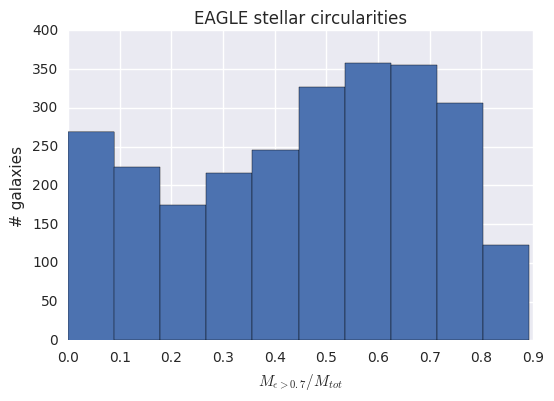

In [101]:
g.e.hist()
plt.title('EAGLE stellar circularities')
plt.ylabel('# galaxies')
plt.xlabel('$M_{\epsilon > 0.7}/M_{tot}$')
plt.savefig('eagle_stellar_circularities_histogram.png')

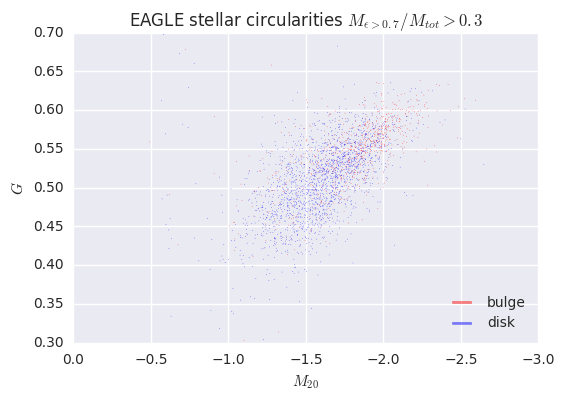

In [102]:
CORTE = .3

gd = g[g.e >  CORTE]
gb = g[g.e <= CORTE]

fig, ax = plt.subplots()

ax.scatter(x=gb.m20, y=gb.gini, c='red',  s=.2, edgecolor='none', label='bulge')
ax.scatter(x=gd.m20, y=gd.gini, c='blue', s=.2, edgecolor='none', label='disk')

ax.legend(loc=4, scatterpoints=100)

plt.xlim(plt.xlim(-3,0)[::-1])
plt.ylim(.3,.7)
plt.xlabel('$M_{20}$')
plt.ylabel('$G$')
plt.title('EAGLE stellar circularities $M_{\epsilon > 0.7}/M_{tot} > %s$' % CORTE)
plt.savefig('eagle_bulge_disk.png')

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


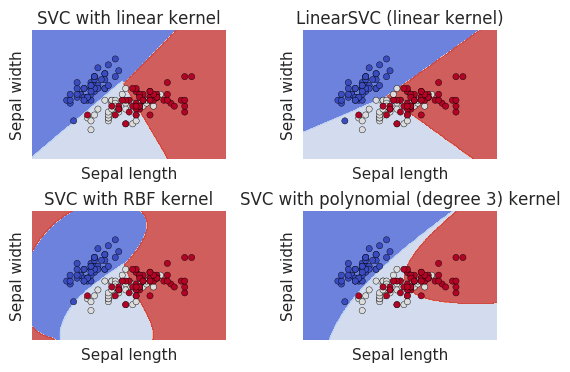

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

## Illustris

http://www.illustris-project.org/data/docs/specifications

In [71]:
morfologías = h5py.File('../illustris/nonparametric_morphologies.hdf5', 'r')
circularidades = h5py.File('../illustris/stellar_circs.hdf5', 'r')

filtros = ['gSDSS', 'iSDSS', 'uSDSS', 'hWFC3']
cámaras = ['cam0', 'cam1', 'cam2', 'cam3']

In [86]:
il = pd.DataFrame()

for filtro in filtros:
    for cámara in cámaras:
        m = pd.DataFrame()
        
        m['id'] = morfologías['Snapshot_135/SubfindID_%s' % cámara]
        
        m['filtro'] = filtro
        m['cámara'] = cámara
        
        m['gini'] = morfologías['Snapshot_135/%s/Gini_%s' % (filtro, cámara)]
        m['m20']  = morfologías['Snapshot_135/%s/M20_%s'  % (filtro, cámara)]
        m['concentration']     = morfologías['Snapshot_135/%s/C_%s'  % (filtro, cámara)]
        m['petrosian_radius']  = morfologías['Snapshot_135/%s/RP_%s' % (filtro, cámara)]
        m['half_light_radius'] = morfologías['Snapshot_135/%s/RE_%s' % (filtro, cámara)]
        
        il = pd.concat([il, m])

In [87]:
c = pd.DataFrame()

c['id'] = circularidades['Snapshot_135/SubfindID']
c['specific_angular_momentum'] = circularidades['/Snapshot_135/SpecificAngMom']
c['e']  = circularidades['Snapshot_135/CircAbove07Frac']

Tanto $G$ como $M_{20}$ vienen rendondeados hasta el segundo decimal, lo que hace que el gráfico se vea "grillado" y desprolijo. Agregamos un poco de ruido a ambas para que las galaxias se vean distribuidas más uniformemente. 

In [88]:
c['tipo'] = c.e.apply(lambda x: 'disco' if x > .3 else 'bola')
il['m20_rand'] = il.m20 + np.random.rand(len(il.m20)) * 0.01
il['gini_rand'] = il.gini + np.random.rand(len(il.gini)) * 0.01

In [89]:
df = pd.merge(il, c, how='inner', on='id')
#df.set_index('id', inplace=True)

In [90]:
g = df[df.filtro == 'gSDSS']

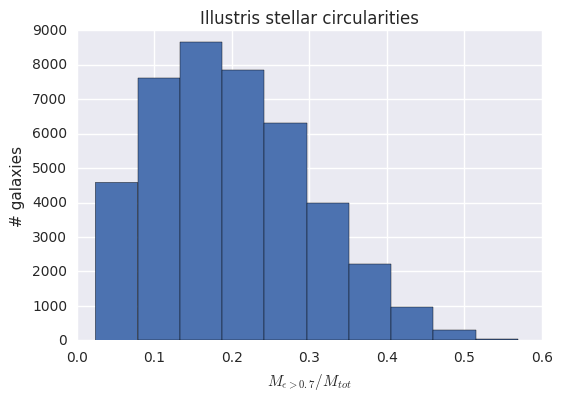

In [96]:
g.e.hist()
plt.title('Illustris stellar circularities')
plt.ylabel('# galaxies')
plt.xlabel('$M_{\epsilon > 0.7}/M_{tot}$')
plt.savefig('illustris_stellar_circularities_histogram.png')

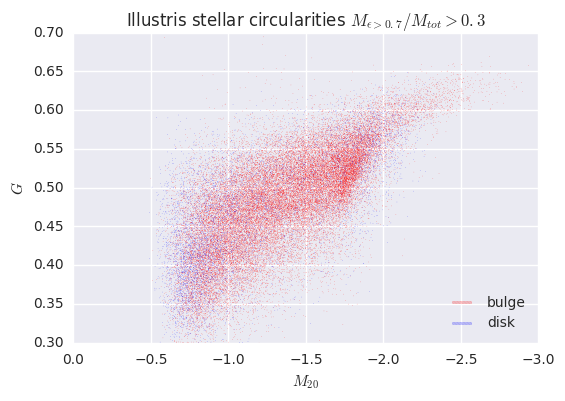

In [95]:
CORTE = .3

gd = g[g.e >  CORTE]
gb = g[g.e <= CORTE]

fig, ax = plt.subplots()

ax.scatter(x=gb.m20_rand, y=gb.gini_rand, c='red',  s=.1, edgecolor='none', label='bulge')
ax.scatter(x=gd.m20_rand, y=gd.gini_rand, c='blue', s=.1, edgecolor='none', label='disk')

ax.legend(loc=4, scatterpoints=100)

plt.xlim(plt.xlim(-3,0)[::-1])
plt.ylim(.3,.7)
plt.xlabel('$M_{20}$')
plt.ylabel('$G$')
plt.title('Illustris stellar circularities $M_{\epsilon > 0.7}/M_{tot} > %s$' % CORTE)
plt.savefig('illustris_bulge_disk.png')

In [48]:
X, y = g[['gini', 'm20', 'concentration', 'petrosian_radius', 'half_light_radius']], g['e']

In [49]:
import sklearn.model_selection

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X.values, y.values, random_state=1)

### AutoML

In [41]:
import sklearn.metrics
import autosklearn
import autosklearn.regression

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=360,
    per_run_time_limit=60,
    initial_configurations_via_metalearning=2,
    ensemble_size=5,
    ensemble_nbest=5,
    seed=1,
    ml_memory_limit=1072
)

In [ ]:
automl.fit(X_train, y_train)

In [ ]:
automl.predict(X_test.values)

In [ ]:
print(automl.show_models())
predictions = automl.predict(X_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))

### TPOT

In [43]:
from tpot import TPOTRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [51]:
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, config_dict='TPOT light', n_jobs=3)
tpot.fit(X_train, y_train)

Optimization Progress:  32%|███▎      | 39/120 [02:24<18:42, 13.85s/pipeline] 

Generation 1 - Current best internal CV score: 0.006922273337841034


Optimization Progress:  49%|████▉     | 59/120 [02:33<03:38,  3.58s/pipeline]

Generation 2 - Current best internal CV score: 0.006922273337841034


Optimization Progress:  64%|██████▍   | 77/120 [02:58<03:00,  4.19s/pipeline]

Generation 3 - Current best internal CV score: 0.006922273337841034


Optimization Progress:  79%|███████▉  | 95/120 [07:12<04:07,  9.89s/pipeline]

Generation 4 - Current best internal CV score: 0.006795954797416926


Generation 5 - Current best internal CV score: 0.00679117813706398

Best pipeline: KNeighborsRegressor(MaxAbsScaler(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False)), KNeighborsRegressor__n_neighbors=79, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=DEFAULT)


TPOTRegressor(config_dict={'sklearn.linear_model.LassoLarsCV': {'normalize': [True, False]}, 'sklearn.linear_model.ElasticNetCV': {'l1_ratio': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ]), '... 0.0001, 0.001, 0.01, 0.1], 'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0, 25.0]}},
       crossover_rate=0.1, cv=5, disable_update_check=False, generations=5,
       max_eval_time_mins=5, max_time_mins=None, mutation_rate=0.9,
       n_jobs=3, offspring_size=20, population_size=20, random_state=None,
       scoring=None, subsample=1.0, verbosity=2, warm_start=False)

In [52]:
tpot.score(X_test, y_test)

0.0066012481379387217

In [55]:
tpot.export('galaxies.py')

In [ ]:
X.plot.scatter(x='m20', y='gini', c='b', s=5, edgecolor='none', ax=ax, marker='.', label='g random Illustris')

### Otras cosas

In [136]:
df.groupby(['filtro', 'cámara'])

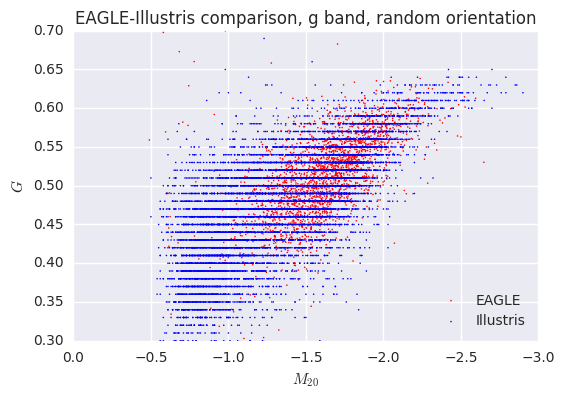

In [103]:
    fig, ax = plt.subplots()
    
    df[(df.filtro == 'g') & (df.orientación == 'rand')] \
        .plot.scatter(x='m20', y='gini', c='r', s=5, edgecolor='none', ax=ax, marker='.', label='EAGLE')
    
    il[(il.filtro == 'gSDSS') & (il.cámara == 'cam0')] \
        .plot.scatter(x='m20', y='gini', c='b', s=5, edgecolor='none', ax=ax, marker='.', label='Illustris')
        
    plt.legend(loc=4)
    plt.xlim(plt.xlim(-3,0)[::-1])
    plt.ylim(.3,.7)
    plt.xlabel('$M_{20}$')
    plt.ylabel('$G$')
    plt.title('EAGLE-Illustris comparison, g band, random orientation')
    plt.savefig('g_random_illustris_eagle_gini_vs_m20.png')

## EAGLE particle data

1. Clonar https://github.com/jchelly/read_eagle.
2. Ejecutar `yaort -S hdf5`.
3. Ejecutar `python ./setup.py install --prefix=/matias/home/.pyenv/versions/3.5.2`.

In [237]:
DATA = '/home/matias/tesis/particle_data/snapshot_028_z000p000/'

def read_dataset(itype, att, nfiles=16):
    """ Read a selected dataset, itype is the PartType and att is the attribute name. """

    # Output array.
    data = []

    # Loop over each file and extract the data.
    for i in range(nfiles):
        f = h5py.File(DATA + 'snap_028_z000p000.%i.hdf5'%i, 'r')
        tmp = f['PartType%i/%s'%(itype, att)][...]
        data.append(tmp)

        # Get conversion factors.
        cgs     = f['PartType%i/%s'%(itype, att)].attrs.get('CGSConversionFactor')
        aexp    = f['PartType%i/%s'%(itype, att)].attrs.get('aexp-scale-exponent')
        hexp    = f['PartType%i/%s'%(itype, att)].attrs.get('h-scale-exponent')
        #print(f['PartType%i/%s'%(itype, att)].attrs.get('VarDescription'))

        # Get expansion factor and Hubble parameter from the header.
        a       = f['Header'].attrs.get('Time')
        h       = f['Header'].attrs.get('HubbleParam')

        f.close()

    # Combine to a single array.
    if len(tmp.shape) > 1:
        data = np.vstack(data)
    else:
        data = np.concatenate(data)

    return data

In [201]:
def read_header():
    """ Read various attributes from the header group. """
    f       = h5py.File(DATA + 'snap_028_z000p000.0.hdf5', 'r')
    a       = f['Header'].attrs.get('Time')         # Scale factor.
    h       = f['Header'].attrs.get('HubbleParam')  # h.
    boxsize = f['Header'].attrs.get('BoxSize')      # L [Mph/h].
    f.close()

    return a, h, boxsize

In [202]:
def read_dataset_dm_mass():
    """ Special case for the mass of dark matter particles. """
    f           = h5py.File(DATA + 'snap_028_z000p000.0.hdf5', 'r')
    h           = f['Header'].attrs.get('HubbleParam')
    a           = f['Header'].attrs.get('Time')
    dm_mass     = f['Header'].attrs.get('MassTable')[1]
    n_particles = f['Header'].attrs.get('NumPart_Total')[1]

    # Create an array of length n_particles each set to dm_mass.
    m = np.ones(n_particles, dtype='f8') * dm_mass 

    # Use the conversion factors from the mass entry in the gas particles.
    cgs  = f['PartType0/Mass'].attrs.get('CGSConversionFactor')
    aexp = f['PartType0/Mass'].attrs.get('aexp-scale-exponent')
    hexp = f['PartType0/Mass'].attrs.get('h-scale-exponent')
    f.close()

    # Convert to physical.
    m = np.multiply(m, cgs * a**aexp * h**hexp, dtype='f8')

    return m

In [ ]:
itype = 4
gn = 1
sgn = 0

gns  = read_dataset(itype, 'GroupNumber')
sgns = read_dataset(itype, 'SubGroupNumber')
mask = np.logical_and(gns == gn, sgns == sgn)
c = read_dataset(itype, 'Coordinates')[mask] * u.cm.to(u.Mpc)

In [249]:
v = read_dataset(itype, 'Velocity')[mask] # cm/s-1
v.shape

(65307, 3)

In [203]:
import astropy.units as u
from astropy.constants import G

In [238]:
class RotationCurve:

    def __init__(self, gn, sgn, centre):

        self.a, self.h, self.boxsize = read_header()
        self.centre = centre

        # Load data.
        #self.gas    = self.read_galaxy(0, gn, sgn, centre)
        #self.dm     = self.read_galaxy(1, gn, sgn, centre)
        self.stars  = self.read_galaxy(4, gn, sgn, centre)
        #self.bh     = self.read_galaxy(5, gn, sgn, centre)

        # Plot.
        #self.plot()
        

    def read_galaxy(self, itype, gn, sgn, centre):
        """ For a given galaxy (defined by its GroupNumber and SubGroupNumber)
        extract the coordinates and mass of all particles of a selected type.
        Coordinates are then wrapped around the centre to account for periodicity. """

        data = {}

        # Load data, then mask to selected GroupNumber and SubGroupNumber.
        gns  = read_dataset(itype, 'GroupNumber')
        sgns = read_dataset(itype, 'SubGroupNumber')
        mask = np.logical_and(gns == gn, sgns == sgn)
        if itype == 1:
            data['mass'] = read_dataset_dm_mass()[mask] #* u.g.to(u.Msun)
        else:
            data['mass'] = read_dataset(itype, 'Mass')[mask] #* u.g.to(u.Msun)
        
        data['coordinates'] = read_dataset(itype, 'Coordinates')[mask] #* u.cm.to(u.Mpc)
        data['velocities']  = read_dataset(itype, 'Velocity')[mask] #* u.cm.to(u.Mpc)

        # Periodic wrap coordinates around centre.
        boxsize = self.boxsize/self.h
        data['coordinates'] = np.mod(data['coordinates'] - centre + 0.5 * boxsize, boxsize) + centre - 0.5 * boxsize

        return data # in CGS units

    def compute_rotation_curve(self, arr):
        """ Compute the rotation curve. """

        # Compute distance to centre.
        r = np.linalg.norm(arr['coords'] - self.centre, axis=1)
        mask = np.argsort(r)
        r = r[mask]

        # Compute cumulative mass.
        cmass = np.cumsum(arr['mass'][mask])

        # Compute velocity.
        myG = G.to(u.km**2 * u.Mpc * u.Msun**-1 * u.s**-2).value
        v = np.sqrt((myG * cmass) / r)

        # Return r in Mpc and v in km/s.
        return r, v

    def plot(self):
        plt.figure()

        # All parttypes together.
        combined = {}
        combined['mass'] = np.concatenate((self.gas['mass'], self.dm['mass'],
            self.stars['mass'], self.bh['mass']))
        combined['coords'] = np.vstack((self.gas['coords'], self.dm['coords'],
            self.stars['coords'], self.bh['coords']))
        
        # Loop over each parttype.
        for x, lab in zip([self.gas, self.dm, self.stars, combined],
                        ['Gas', 'Dark Matter', 'Stars', 'All']):
            r, v = self.compute_rotation_curve(x)
            plt.plot(r*1000., v, label=lab)

        # Save plot.
        plt.legend(loc='center right')
        plt.minorticks_on()
        plt.ylabel('Velocity [km/s]'); plt.xlabel('r [kpc]')
        plt.xlim(1, 50); plt.tight_layout()
        #plt.savefig('RotationCurve.png')
        #plt.close()

```
Tabla: SubHalo
Columnas: Stars_Spin_x, Stars_Spin_y, Stars_Spin_z [pkpc km s-1] L/M
GroupNumber
SubGroupNumber = 0
Image_box IS NOT NULL
CentreOfMass_x, CentreOfMass_y, CentreOfMass_z [cMpc]
CentreOfPotential_x, CentreOfPotential_y, CentreOfPotential_z [cMpc]
MassType_Star > 1e10 [M\*]


Tabla: Magnitudes
u_nodust [mag]
g_nodust
r_nodust
i_nodust

(sin polvo, absoluta, rest-frame, apertura 30 pkpc)

tipo partícula: estrallas (4)
centro de masa, grupo, subgrupo = 0
momento angular -> dirección del momento angular total (coordenadas propias)
rotar el sistema
sacar el momento angular en z
```

In [239]:
centre = np.array([12.08808994,4.47437191,1.41333473])
x = RotationCurve(1, 0, centre)

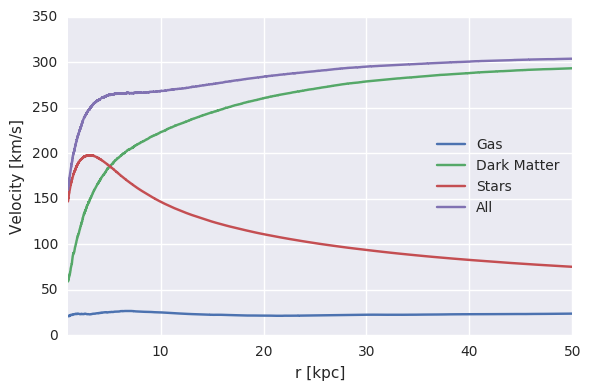

In [211]:
centre = np.array([12.08808994,4.47437191,1.41333473])
x = RotationCurve(1, 0, centre)

### Programa Susana

In [248]:
def matriz_rotación(Jx, Jy, Jz):
    """Convenciones
       * http://mathworld.wolfram.com/EulerAngles.html
       * https://en.wikipedia.org/wiki/Euler_angles#Angles_of_a_given_frame
    """
    
    J = np.array([Jx, Jy, Jz])
    Jx, Jy, Jz = J / np.mod(J)
    
    ## obtención de ángulos de Euler a partir de J
    
    # 1. phi
    cos_phi = Jy / np.sqrt(1 - Jz**2)
    sin_phi = Jx / np.sqrt(1 - Jz**2)

    # 2. theta
    cos_theta = Jz
    sin_theta = np.sqrt(1 - Jz**2)

    # 3. psi = 0
    cos_psi = 1
    sin_psi = 0
    
    # elementos de matriz
    a11 =   cos_psi * cos_phi - cos_theta * sin_phi * sin_psi
    a12 =   cos_psi * sin_phi + cos_theta * cos_phi * sin_psi
    a13 =   sin_psi * sin_theta
    a21 = - sin_psi * cos_phi - cos_theta * sin_phi * cos_psi
    a22 = - sin_psi * sin_phi + cos_theta * cos_phi * cos_psi
    a23 =   cos_psi * sin_theta
    a31 =   sin_theta * sin_phi
    a32 = - sin_theta * cos_phi
    a33 =   cos_theta
    
    A = np.array([ [a11, a12, a13],
                   [a21, a22, a23],
                   [a31, a32, a33] ])
    
    return A

In [ ]:
# los datos (las coordenadas y las velocidades) vienen en tablas (colección de vectores fila)
# la matrix de rotación A es para ir del sistema estático al sistema del objeto
# queremos traer el objeto al sistema de referencia estático, por ende
# el procedimiento consiste en invertir (transponer) la matrix A y aplicarla a vectores columna
# x = A.T * x'
# sin embargo como x' son vectores fila (es decir x'.T) hay que premultiplcar en vez de postmultiplicar
# x = (A.T * x').T = x'.T * A
# en este caso la matriz A queda sin transponer

A = matriz_rotación(Jx, Jy, Jz)

# centro de masa

r = r - r_centro
r = np.dot(r, A)
v = np.dot(v, A)
# podría optimizar anulando z en r o v
# momento angular específico
j = np.cross(r, v)
jz = j[:,2]


```
pro rotador,x,y,z,vx,vy,vz,m,$
            Jx_total,Jy_total,Jz_total,Jmod,$
            a11, a12, a13, a21, a22, a23, a31, a32, a33

     jx=m*(y*vz-z*vy)
     jy=m*(z*vx-x*vz)
     jz=m*(x*vy-y*vx)
```

In [ ]:
  ;================================================================================
  ;       ROTATION 

  ;****** Selecciono los x,y,z,vx,vy,vz de los bariones dentro de 1.5 ropt
  ;aopts=where(rgal le 1.5*rcar(i),nopts)
  aopts=where(rgal le rcar(i),nopts) ; PARA COMPARACION CON PEDRO
  xsopt=xgal(aopts)
  ysopt=ygal(aopts)
  zsopt=zgal(aopts)
  rsopt=sqrt(xsopt^2.+ysopt^2.+zsopt^2.)
  vxsopt=vxgal(aopts)
  vysopt=vygal(aopts)
  vzsopt=vzgal(aopts)
  msopt=mgal(aopts)

;xx agrego para pedro
  mst_ropt(i)=total(msopt)
    

  ;***********    ROTACION    **************
  ;*** uso la funcion rotadora
  rotador,xsopt,ysopt,zsopt,vxsopt,vysopt,vzsopt,msopt,$
  Jxs_total,Jys_total,Jzs_total,Jmod_s,$
  a11, a12, a13, a21, a22, a23, a31, a32, a33

  ;chequeo
  rotJxs_total=a11*Jxs_total+a12*Jys_total+a13*Jzs_total
  rotJys_total=a21*Jxs_total+a22*Jys_total+a23*Jzs_total
  rotJzs_total=a31*Jxs_total+a32*Jys_total+a33*Jzs_total
  jmodrots_total=sqrt(rotJxs_total^2.+rotJys_total^2.+rotJzs_total^2.)
  print,'Js sin rotar(x,y,z):',Jxs_total,Jys_total,Jzs_total
  print,'Js rotado (x,y,z)  :',rotJxs_total,rotJys_total,rotJzs_total
                      
  ;=======================================================================================
  ; Roto r, v 
  rotxs=a11*xgal+a12*ygal+a13*zgal
  rotys=a21*xgal+a22*ygal+a23*zgal
  rotzs=a31*xgal+a32*ygal+a33*zgal
  ; r rotado
  rotrs_esf=sqrt(rotxs^2.+rotys^2.+rotzs^2.)
  rotrs=sqrt(rotxs^2.+rotys^2.)
  ; v
  rotvxs=a11*vxgal+a12*vygal+a13*vzgal
  rotvys=a21*vxgal+a22*vygal+a23*vzgal
  rotvzs=a31*vxgal+a32*vygal+a33*vzgal
  ; vtan rotada
  rotvfis=sqrt(rotvxs^2.+rotvys^2.)
  ;momento angular rotado especifico
  jxsrot=(rotys*rotvzs-rotzs*rotvys)
  jysrot=(rotzs*rotvxs-rotxs*rotvzs)
  jzsrot=(rotxs*rotvys-rotys*rotvxs)
  jmods=sqrt(jxsrot^2.+jysrot^2.+jzsrot^2.)
  
  ;** Calculo la energía **
  ;** Redefino el punto cero en el radio virial: tomo como cero la energía Ep de la última partícula**
  avir=where(rotrs_esf le rvir(i),navir)
  ord_rotrs=sort(rotrs_esf)
  egal_rvir=egal(ord_rotrs[navir-1])
  ett = (egal-egal_rvir) + 0.5*(rotvxs^2. + rotvys^2. + rotvzs^2.)

  ;** Patricia está calculando con el rvir en vez de ropt
  aener=where(rotrs_esf le rvir(i),naener)
  ;aener=where(rotrs_esf le 2.5*ropt(i),naener)
  ett=ett(aener)
  jzsrot=jzsrot(aener)
  rotrs_esf=rotrs_esf(aener)
  
  ;** define maximum caustic del lnJzs
  lnjzs=alog(abs(jzsrot))
  ;lnjzs=jzsrot

  ;** Calcula la caústica para el ln de j **
  delta=2500.
  xmin=min(ett)
  xmax= max(ett)

  defcaustic,ett,lnjzs,naener,xmin,xmax,delta,xdle2,ydle2,ylnorm,nhist

  ;** plot lnJ + caus **
if flag_plot_caus gt 0 then begin
  device,filename = dir_out + '/Ener/' + srun + '/scatter_LnJ_' + '_G'+strcompress(string(Ngr(i)),/remove_all)+'_S'+strcompress(string(Nsub(i)),/remove_all)+ '.eps'
  device,xsize=25,ysize=20
  !x.margin = [10,3]
  !y.margin = [4,2]

  !p.multi = [0,1,1]
  !p.background = 255
  ymin=min(lnjzs)
  ymax=max(lnjzs)
  xmin=min(ett/1e5)
  xmax= max(ett/1e5)

  plot,ett/1.e5,lnjzs,color = negro,psym = 3,symsize =0.1, xr=[xmin,xmax],yr=[ymin,ymax],xstyle=1,xtitle = 'Etotal (1/e5)',ytitle ='Ln |Jz|',title='EvsJ',charsize=2, thick=8, ystyle=1

  oplot,  xdle2/1e5,ydle2, color=verde,linestyle=0;psym=2
  ;if naeners gt 0 then oplot, ettstars/1e5,lnjzstars, color=azul, psym=3
  ;oplot,  xx/1e5,zzz, color=rojo,linestyle=0;psym=2

endif

  xmin=min(ett)
  xmax= max(ett)
  ;** Interpolación ***
  interpolator, naener,nhist,ett,xdle2,ydle2,jlsinter
  epi=jzsrot/e_num^jlsinter

if flag_plot_eper gt 0 then begin
  device,filename = dir_out + '/Ener/' + srun + '/scatter_epi_' + '_G'+strcompress(string(Ngr(i)),/remove_all)+'_S'+strcompress(string(Nsub(i)),/remove_all)+ '.eps'
  device,xsize=25,ysize=20
  !x.margin = [10,3]
  !y.margin = [4,2]
  !p.multi = [0,1,1]
  !p.background = 255
  ymin=min(epi)
  ymax=max(epi)
  ;ymin=min(lnjzs/1.e3)
  ;ymax=max(lnjzs/1.e3)
  xmin=min(ett/1e5)
  xmax= max(ett/1e5)

  plot,ett/1.e5,epi,color = negro,psym = 3,symsize =0.1, xr=[xmin,xmax],yr=[ymin,ymax],xstyle=1,xtitle = 'Etotal (1/e5)',ytitle ='Epi',title='EpivsE',charsize=2, thick=8, ystyle=1

endif


  if flag_histo gt 0 then begin
  ;histograma reformado Simon
  device,filename = dir_out + '/Ener/' + srun + '/hist_J2_' + '_G'+strcompress(string(Ngr(i)),/remove_all)+'_S'+strcompress(string(Nsub(i)),/remove_all)+ '.eps'
  device,xsize=25,ysize=20
  !x.margin = [10,3]
  !y.margin = [4,2]
  !p.multi = [0,1,1]
  !p.background = 255

  delta=0.05
  xmin=-2
  xmax=2
  ymin=0
  ymax=0.10
  
  msimon=dblarr(naener)
  msimon(*)=1
  plotmassw,epi,naener,msimon,xmin,xmax,delta,xh2,yh2,xf,yf,xf2

  plot,xh2,yh2,color = negro,psym = 10,symsize =0.1, xr=[xmin,xmax], yr=[ymin,ymax], xstyle=1, xtitle = '!9e = !3 J!Dz!N/J!D!Dz,max!N(E)', ytitle ='F', title='hist J', charsize=2, thick=2, ystyle=1
                  
  endif ; flag_histo  

## Registro

Algunos acrónimos

* SED: spectral energy distribution
* SFR: star formation rate
* PSF: point-spread function
* RT: radiative transfer
* ISM: interstellar medium
* SPS: stellar population synthesis

### Publicaciones

* Abraham 2003: antecedente de Lotz 2004 (no es tan importante)
* *Conselice 2003*: definiciones de parámetros
* Lotz 2004: morfologías no paramétricas

**Illustris**

* Schaye 2014: morfologías
* Snyder 2015: Gini-M20 (Simulated Galaxy Morphologies at $z = 0$) https://arxiv.org/pdf/1502.07747.pdf
* Torrey 2015: FITS https://arxiv.org/pdf/1411.3717.pdf
* Genel 2015: galactic angular momentum

**EAGLE**

* Trayford 2015: FITS
* Lagos 2017: galactic angular momentum

**Extra**

* A catalog of visual-like morphologies in the 5 CANDELS fields using deep-learning — https://arxiv.org/abs/1509.05429

### Notas

**Bandas**

* u *ultravioleta*
* b *azul*
* g/v *verde/visible*
* r *rojo*
* i *infrarrojo*


### TODO

**De antes**

* ¿Qué hace el código de Lotz con los parámetros de `morph.dat` (como PSF)?
* ~~Invertir eje SRF/M~~
* ~~Arreglar G-M20~~
* ~~r face deberían ser 3625 galaxias~~
* Comparación con g-r de Illustris -> cambio por g-i porque Illustris no tiene la banda r
* EAGLE zoo (clasificación visual)
* Machine learning
* momento angular eagle (paper lagos)
* ~~Gini-M20~~
  * r face
  * g face
  * g rand
* ~~Gini-M20 superpuestos Illustris / EAGLE en g_face~~
* ~~Gini-M20 superpuestos g_face / g_rand~~

**11 de julio**

* Aplicar ML de Illustris a EAGLE
* EAGLE zoo
* Documento Latex
  * Intro
  * Iraf
  * Lotz
  * Gini M20 vs propiedades (EAGLE)
    * Todos los plots que hay
  * ML Illustris
    * Mención de la técnica usada
  * ML de Illustris a EAGLE
  
**15 de julio**

* Gráfico de épsilon sobre G-M20 en Illustris
* Ver qué onda la función F. *En Lotz 2004 no están los parámetros de la recta que separa las galaxias*.
* Ver de calcular el épsilon para EAGLE
* *¿Cuál es la fracción bola-disco en el cielo? Serviría para calibrar mejor el corte de la fracción épsilon > 0.7*

**22 de agosto**

* Es bueno el método de Lotz para clasificar morfológicamente a las galaxias? Eso podemos evaluar comparando la clasificación de ella con la visual y con la dinámica (elipticidad de James). Podríamos si vemos que tiene problemas pensar en usar el método de Lucas. Pero creo que él encontraba un buen acuerdo.

Lo de las curvas de nivel está difícil. No es imposible pero habría que definir un centroide a partir del cual comenzar a acumular galaxias según algún criterio (circular, elíptico, etcétera) hasta cubrir el 68% y el 95% de la población de galaxias.

Esto es para ver el nivel de solapamiento entre galaxias de distinto tipo.

A mi parecer con los datos de las simulaciones el G-M20 si bien muestra una tendencia de separación, es apenas eso y las galaxias se muestran bastante mezcladas.

Esto llevaría a que la simulación está mal o a que el método de Lotz no es completamente aceptable (al parecer lo es).

- G-M20, según $UB > 1$ (rojas) y $UB < 1$ (azules), figura 2 y en menor medida figuras 3 y 4.

  - Azules tienen SFR más alto. 
  - Rojas son galaxias "apagadas".
  - G-M20 segmentado por M∗ muestra tendencias disímiles (figura 6).
  
- *Tendencias morfológicas*, figura 5.

  - SFR versus M∗
  - overdensity versus M∗
  - SSFR versus compactness
  
- *Tendencias cinemáticas*, figuras 7 y 8.

  - (β) twice the fraction of star particles with e < 0
  - specific angular momentum (escala como M^2/3)
  - $κ_{rot}$, the  fraction  of  kinetic  energy  occupied  by ordered  rotational  motion

Versus F, quiescent  fraction (básicamente fracción de galaxias con SSFR menor a cierto umbral), morfología por densidad (que presupone una clasificación; figura 9).

- Discusión
  
  - Alcanza con ajustar las distribuciones para M∗ (stellar mass function) y SFR en $z=0$.
  - Depende de cómo está modelado el feedback (SFR depende de la morfología).
  - Pareciera ser que la clasificación entre disco/bulto aporta poca información.
  
 
  

* Usando algoritmos de machine learning puede conseguirse una mejora en la clasificación? de cuánto?

Seguro que sí pero desde ya se ve que hay que incluir más atributos, dos es poco.

Illustris ofrece valores precalculados de (Gini,M20,C,rP,rE) usando filtros (gSDSS, iSDSS, uSDSS, and hWFC3) en rest-frame para z=0.

* Si el método es bueno, la clasificación debería correlacionar por ejemplo con la SFR y con los colores de las galaxias. O sea, por ej, aquellas galaxias con Gini alto según Lotz deberían ser más rojas y formar menos estrellas. Eso se encuentra?
* Existe algún bias debeido a la orientación random/face-on?
* Existe bias con respecto a la clasificación visual?
* Depende la clasificación del filtro utilizado?
* Comparación con Illustris

https://github.com/zooniverse/Galaxy-Zoo/blob/master/public/locales/es.json

¿Por qué es importante la morfología de las galaxias?"

En primer lugar, la morfología de una galaxia es el rastro de la dinámica orbital de las estrellas que la conforman, pero también lleva consigo la huella de los procesos que conducen la formación estelar y la actividad nuclear en las galaxias. La morfología visual crea clasificaciones que están fuertemente relacionadas con parámetros físicos. Para dar un ejemplo simple, la presencia de múltiples núcleos y características de amplios escombros, indica que el mecanismo dominante que conlleva a la formación estelar es una fusión en proceso. De igual manera, la ausencia de dichas características implica que la evolución de la galaxia podría estar siendo impulsada por procesos internos ('secular').

"reference": "Tradicionalmente, la morfología se ha derivado ya sea en la inspección visual de imágenes de galaxias o vía parámetros morfológicos como la concentración, asimetría, agrupamiento, M20, el coeficiente de Gini, etc. En estricto rigor, estos parámetros son 'representantes' morfológicos, cada uno con sus respectivos prejuicios contaminantes, que comúnmente son verificados y ajustados mediante inspección visual. Una aproximación visual es generalmente más resistente al cambio de señal a ruido y resolución en las imágenes, convirtiéndolo en un método ideal a la hora de determinar la morfología de las galaxias. Sin embargo, parámetros morfológicos han sido de gran valor a la hora de clasificar grandes conjuntos de datos a escala de exploraciones, en los que la inspección visual realizada por individuos (o pequeños grupos de investigadores) significaría un altísimo y demandante consumo de tiempo.

https://jscholarship.library.jhu.edu/bitstream/handle/1774.2/40300/PETH-DISSERTATION-2016.pdf?sequence=1&isAllowed=y

https://github.com/vrodgom/statmorph